# BoneawareAI

Authors: Karthik Subramanian, Charles Green, Sai Anurag Pichika, Saarang Prabhuram


## Setup

### Load Extensions

Before getting started we need to run some standard code to set up our environment. You'll need to execute this code again each time you start the notebook.

First, run this cell to load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This enables us to modify `.py` source files and reintegrate them into the notebook, ensuring a smooth editing and debugging experience.

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 24 18:20:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P8              4W /   78W |     715MiB /   6144MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [47]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [422]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [423]:
import os
PROJECT_PATH = 'BoneawareAI'
GOOGLE_DRIVE_PATH = f'/content/drive/MyDrive/{PROJECT_PATH}'
os.chdir(GOOGLE_DRIVE_PATH)
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/BoneawareAI'

In [424]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH) # this is important for the imports in the .py files to work

In [69]:
%pip install pyyaml==5.4.1
%pip install boto3
%pip install configparser
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Local Setup OR Google Drive
Run the cell below regardless of whether you are using google drive or local setup.

In [48]:
# if running locally set GOOGLE PATH
import sys
isLocal = False
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')
  isLocal = True

Running locally.


### Imports

In [49]:
# RUN LOCALLY
import sys
if isLocal:
    sys.path.append('../src')  # Add the 'src' folder to Python's module search path
    sys.path.append('../datasets')  # Add the 'datasets' folder to Python's module search path
    sys.path.append('../notebooks')  # Add the 'notebooks' folder to Python's module search path
    print('Modules added correctly, locally.')
else:
    sys.path.append('src')  # Add the 'src' folder to Python's module search path
    sys.path.append('datasets')  # Add the 'datasets' folder to Python's module search path
    sys.path.append('notebooks')  # Add the 'notebooks' folder to Python's module search path
    print('Modules added correctly on colab.')

Modules added correctly, locally.


In [50]:
from image_utils import set_seed, MURADataset, load_data, confirm_images_and_labels, count_body_parts, count_positive_negative, count_body_parts_with_augmentations

In [51]:
from metrics import plot_confusion_matrix, plot_roc_curve, compute_class_weights, calculate_metrics, calculate_metrics_per_body_part, evaluate_model

In [52]:
import torch

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")


Using device = cuda


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Set Seed

This is so the results can be duplicated, ensure that the seed is set in the image_utils.py file, if you want a random seed, import random and set a random number

In [54]:
set_seed(42)

In [55]:
import os
import torch
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Preprocessing
Get the dataset, perform data augmentation to get finalized MURA dataset

In [56]:
# Downloading MURA dataset and unzipping the file (this one takes time)
from data_loader import download_dataset
from constants import DATASETS_FOLDER, MURA_DATASET
from helpers.utils import unzip_file

if (isLocal):
    # Define the parent directory and dataset path
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go to the parent directory
    datasets_folder = os.path.join(parent_dir, DATASETS_FOLDER)   # Define datasets folder in the parent directory
    dataset_path = os.path.join(datasets_folder, MURA_DATASET)    # Full path to the dataset file
else:
    datasets_folder = os.path.join(GOOGLE_DRIVE_PATH, DATASETS_FOLDER) # Define datasets folder in the parent directory
    dataset_path = os.path.join(datasets_folder, MURA_DATASET) # Full path to the dataset file

# Ensure the datasets folder exists
os.makedirs(datasets_folder, exist_ok=True)

# Check if the dataset is already downloaded
if not os.path.exists(dataset_path):
    print(f"{MURA_DATASET} not found in {DATASETS_FOLDER}. Downloading and extracting...")
    # Download and unzip the dataset
    download_dataset(MURA_DATASET, datasets_folder)
    unzip_file(dataset_path)
else:
    print(f"{MURA_DATASET} already exists in {DATASETS_FOLDER}. Skipping download.")

MURA-v1.1.zip already exists in datasets. Skipping download.


In [57]:
if (isLocal):
    data_dir = "../datasets/MURA-v1.1"
else:
    data_dir = os.path.join(datasets_folder, 'MURA-v1.1')

batch_size = 32

# Load training and validation data
train_loader, valid_loader = load_data(data_dir, batch_size=batch_size)

Loaded 147232 training samples and 3197 validation samples.


In [58]:
print("Training Data:")
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {len(images)}, Labels: {labels}")
    break

# Test the validation DataLoader
print("Validation Data:")
for images, labels in valid_loader:
    print(f"Batch size: {len(images)}, Labels: {labels}")
    break

Training Data:
Batch size: 32, Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1])
Validation Data:
Batch size: 32, Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [436]:
# Access the datasets from the DataLoaders
train_dataset = train_loader.dataset
valid_dataset = valid_loader.dataset

# Example: Print the length of the datasets
print(f"Number of samples in the training dataset: {len(train_dataset)}")
print(f"Number of samples in the validation dataset: {len(valid_dataset)}")

Number of samples in the training dataset: 147232
Number of samples in the validation dataset: 3197


In [437]:
#16 minutes to confirm on local, does not need to run as you can always use the dataset to confirm as well
#confirm_images_and_labels(train_dataset, "train")
#confirm_images_and_labels(valid_dataset, "valid")

In [438]:
count_body_parts(train_dataset, "train")
count_body_parts(valid_dataset, "valid")

Train dataset body part distribution:


,BodyPart,Count
0,XR_WRIST,9752
1,XR_SHOULDER,8379
2,XR_HAND,5543
3,XR_FINGER,5106
4,XR_ELBOW,4931
5,XR_FOREARM,1825
6,XR_HUMERUS,1272


Valid dataset body part distribution:


,BodyPart,Count
0,XR_WRIST,659
1,XR_SHOULDER,563
2,XR_ELBOW,465
3,XR_FINGER,461
4,XR_HAND,460
5,XR_FOREARM,301
6,XR_HUMERUS,288


In [439]:
# Example usage with 3 augmentations,  adjust the augmentations as needed
count_body_parts_with_augmentations(train_dataset, "train", num_augmentations=3)
count_body_parts_with_augmentations(valid_dataset, "valid", num_augmentations=3)

Train dataset body part distribution (with augmentations):


,BodyPart,OriginalCount,AugmentedCount
0,XR_WRIST,9752,39008
1,XR_SHOULDER,8379,33516
2,XR_HAND,5543,22172
3,XR_FINGER,5106,20424
4,XR_ELBOW,4931,19724
5,XR_FOREARM,1825,7300
6,XR_HUMERUS,1272,5088


Valid dataset body part distribution (with augmentations):


,BodyPart,OriginalCount,AugmentedCount
0,XR_WRIST,659,2636
1,XR_SHOULDER,563,2252
2,XR_ELBOW,465,1860
3,XR_FINGER,461,1844
4,XR_HAND,460,1840
5,XR_FOREARM,301,1204
6,XR_HUMERUS,288,1152


In [440]:
# Count positive/negative cases in the training dataset (with 3 augmentations)
count_positive_negative(train_dataset, "train", num_augmentations=3)

# Count positive/negative cases in the validation dataset (with 3 augmentations)
count_positive_negative(valid_dataset, "valid", num_augmentations=3)

Train dataset positive/negative distribution (with augmentations):


,BodyPart,Negative,Positive,AugmentedNegative,AugmentedPositive
0,XR_ELBOW,2925,2006,11700,8024
1,XR_FINGER,3138,1968,12552,7872
2,XR_FOREARM,1164,661,4656,2644
3,XR_HAND,4059,1484,16236,5936
4,XR_HUMERUS,673,599,2692,2396
5,XR_SHOULDER,4211,4168,16844,16672
6,XR_WRIST,5765,3987,23060,15948


Valid dataset positive/negative distribution (with augmentations):


,BodyPart,Negative,Positive,AugmentedNegative,AugmentedPositive
0,XR_ELBOW,235,230,940,920
1,XR_FINGER,214,247,856,988
2,XR_FOREARM,150,151,600,604
3,XR_HAND,271,189,1084,756
4,XR_HUMERUS,148,140,592,560
5,XR_SHOULDER,285,278,1140,1112
6,XR_WRIST,364,295,1456,1180


### Other Datasets

# Model

### DenseNet

In [441]:
from models.densenet import DenseNet

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the DenseNet
model = DenseNet(num_blocks=3, num_layers_per_block=4, growth_rate=32, reduction=0.5).to(device)


In [442]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# 6. Define Loss, Optimizer, and Scheduler
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
weights = torch.tensor([1.0, 3.0]).to(device)  # Adjust according to dataset imbalance
criterion = nn.BCEWithLogitsLoss()


In [443]:
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, classification_report,
    precision_recall_fscore_support, cohen_kappa_score, roc_curve
)

In [444]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, device='cuda'):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = valid_loader

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"{phase} Progress")

            for i, (inputs, labels) in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    try:
                        with autocast(enabled=torch.cuda.is_available()):  # Mixed precision
                            outputs = model(inputs).view(-1)  # Ensure outputs have shape [batch_size]
                            labels = labels.view(-1)          # Ensure labels have shape [batch_size]
                            loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                        preds = (outputs > 0.5).float()  # Convert logits to predictions
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels)

                        progress_bar.set_postfix(loss=loss.item(), accuracy=(running_corrects.double() / ((i + 1) * inputs.size(0))).item())

                    except Exception as e:
                        print(f"Error in batch {i} of {phase}: {e}")
                        continue

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            train_history[f'{phase}_loss'].append(epoch_loss)
            train_history[f'{phase}_acc'].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_history

In [ ]:
# 8. Train the Model
model, train_history = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=10)

In [29]:
# Save the model
#torch.save(model.state_dict(), 'densenet_mura.pth')
# Load the model
if device == 'cuda':
    model.load_state_dict(torch.load('densenet_mura.pth'))
elif device == 'mps':
    model.load_state_dict(torch.load('densenet_mura.pth', map_location=torch.device('mps')))
else:
    model.load_state_dict(torch.load('densenet_mura.pth', map_location=torch.device('cpu')))
# Evaluate on validation set
model.eval()

C:\Users\green\AppData\Local\Temp\ipykernel_29132\2469493041.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('densenet_mura.pth', map_lo

DenseNet(
  (init_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (0): DenseBlock(
      (block): Sequential(
        (0): DenseLayer(
          (layer): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3): Dropout(p=0.2, inplace=False)
          )
        )
        (1): DenseLayer(
          (layer): Sequential(
            (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(96, 32, kernel_size=(3, 3), stri

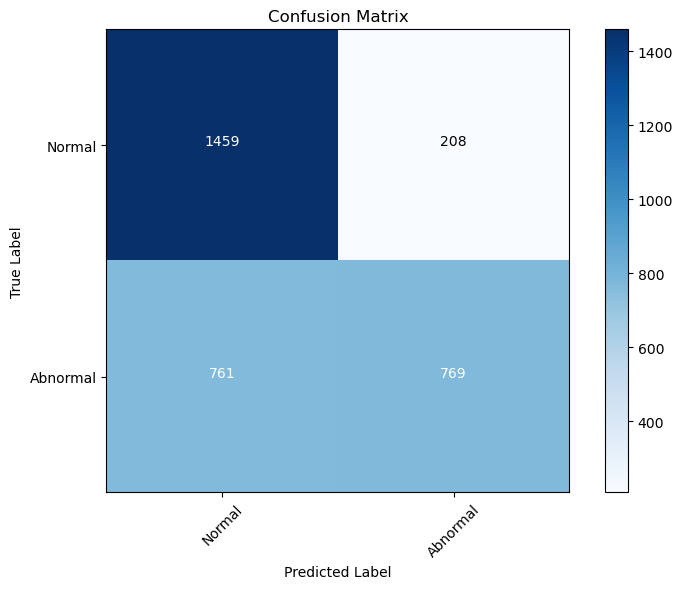

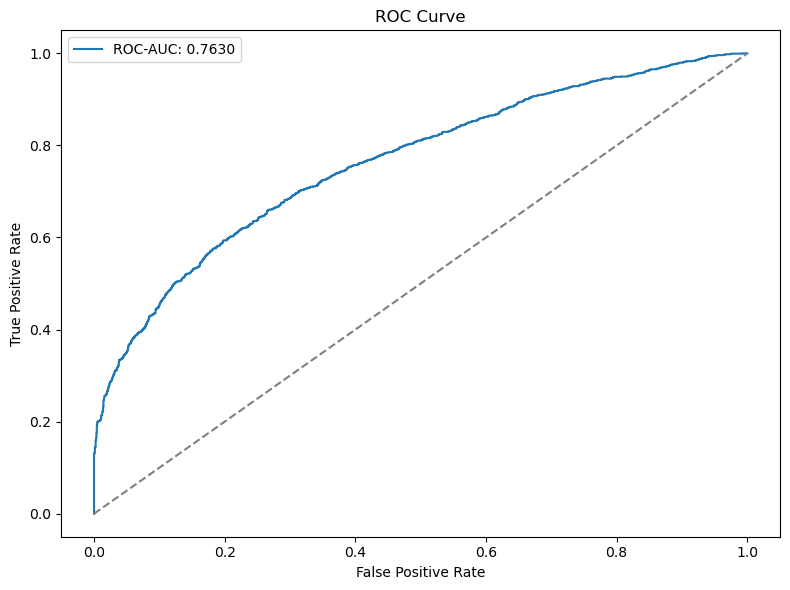

Global Metrics:
{'Accuracy': 0.6969033468877073, 'Precision': 0.7871033776867963, 'Recall': 0.5026143790849673, 'F1 Score': 0.6134822497008376, 'Specificity': 0.8752249550089982, 'ROC-AUC': 0.7630301390702252, "Cohen's Kappa": 0.3835356545801919, 'Kappa 95% CI Lower': 0.3599958727089543, 'Kappa 95% CI Upper': 0.4070754364514295, 'Loss': 0.5798552333749306}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.88      0.75      1667
         1.0       0.79      0.50      0.61      1530

    accuracy                           0.70      3197
   macro avg       0.72      0.69      0.68      3197
weighted avg       0.72      0.70      0.69      3197

Metrics per body part:
             Accuracy  Precision    Recall  F1 Score  Specificity   ROC-AUC  \
XR_WRIST     0.748103   0.844920  0.535593  0.655602     0.920330  0.816977   
XR_FOREARM   0.707641   0.888889  0.476821  0.620690     0.940000  0.790684   
XR_HAND      0.656522   0.76271

,Accuracy,Precision,Recall,F1 Score,Specificity,ROC-AUC,Cohen's Kappa,Kappa 95% CI Lower,Kappa 95% CI Upper,Loss
0,0.696903,0.787103,0.502614,0.613482,0.875225,0.76303,0.383536,0.359996,0.407075,0.579855


In [447]:
# Evaluate on validation set
metrics = evaluate_model(model, valid_loader, dataset=valid_dataset, criterion=criterion)
display(metrics)

## Visualizations

In [ ]:
from visualizer import find_last_conv_layer, run_gradcam, GradCAM, visualize_gradcam_examples

In [38]:
layer_name, target_layer = find_last_conv_layer(model)
print(layer_name)
print(target_layer)


features.4.block.3.layer.2
Conv2d(208, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
body_parts = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM"]

In [63]:
print(valid_loader.dataset.image_df)
print(valid_loader.dataset.label_map)
print(valid_loader.dataset.root_dir)

                                             image_path
0     MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1     MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2     MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3     MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4     MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
...                                                 ...
3192  MURA-v1.1/valid/XR_FINGER/patient11967/study1_...
3193  MURA-v1.1/valid/XR_FINGER/patient11967/study1_...
3194  MURA-v1.1/valid/XR_FINGER/patient11738/study1_...
3195  MURA-v1.1/valid/XR_FINGER/patient11738/study1_...
3196  MURA-v1.1/valid/XR_FINGER/patient11738/study1_...

[3197 rows x 1 columns]
{'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/': 1, 'MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/': 1, 'MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/': 1, 'MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/': 1, 'MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/': 

[DEBUG] Batch Inputs Shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


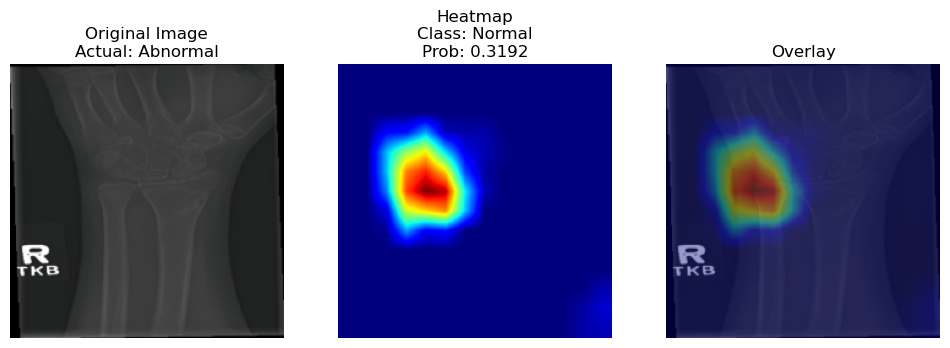

In [122]:
run_gradcam(model, valid_loader, target_layer, class_names=["Normal", "Abnormal"], device=device)

In [78]:
# Example usage
# Assume `model`, `train_dataset`, `val_dataset`, and `gradcam` are defined
visualize_gradcam_examples(
    model=model, 
    dataset=valid_dataset, 
    num_examples=5, 
    dataset_type="valid", 
    body_part="XR_ELBOW", 
    #patient_name="patient123"
)

KeyError: 'Label not found for study path: MURA-v1.1/valid/../../../MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/'

In [34]:
gradcam = GradCAM(model, target_layer)

heatmap, predicted_class_idx, predicted_prob = gradcam.compute_heatmap(input_batch)

NameError: name 'input_batch' is not defined

In [ ]:
predicted_class_name = class_labels[predicted_class_idx]
print(f"Predicted class: {predicted_class_name} (index: {predicted_class_idx}, probability: {predicted_prob:.2%})")
